In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Arial')
from math import nan

from qtrendutils import linfit_utils as linfit
from qtrendutils import mapplot_utils as mymaps
from matplotlib.patches import Rectangle
from matplotlib.colors import BoundaryNorm

import warnings
warnings.filterwarnings('ignore')

import sys
from qtrendutils import colormap_utils as mycolors
from qtrendutils import averaging_utils as avg
from qtrendutils import colorbar_utils as cbars

In [2]:
plotpath="/project/cas/islas/python_plots/qtrend_paper/figures/supplemental/"

In [3]:
era5_binned = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/fig3/obsbinned_ai30_pr15_weighted.nc")
cmip6_binned = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/fig3/cmip6binned_ai30_pr15_weighted.nc")

In [4]:
landfrac = xr.open_dataset("../../DATA_SORT/LANDFRAC_LENS2.nc")
landfrac = landfrac.landfrac
landfrac = landfrac.where(landfrac > 0, nan)
landfrac = landfrac.where(landfrac.lat > -60, nan) # omitting Antarctica

cmip6_trends = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/vptrends_CMIP6.nc")
cmip6_trends['lon'] = landfrac.lon ; cmip6_trends['lat'] = landfrac.lat
era5_trends = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/vptrends_ERA5.nc")
era5_trends['lon'] = landfrac.lon ; era5_trends['lat'] = landfrac.lat

In [5]:
cmip6_tasland = avg.cosweightlonlat(cmip6_trends*landfrac, 0, 360, -90 ,90)
era5_tasland = avg.cosweightlonlat(era5_trends*landfrac, 0, 360, -90, 90)

cmip6_tasgm = avg.cosweightlonlat(cmip6_trends, 0, 360, -90 ,90)
era5_tasgm = avg.cosweightlonlat(era5_trends, 0, 360, -90, 90)

In [6]:
### Precipitation binned.
p_binned_era5 = era5_binned.prgpcc_gpcc
p_binned_cmip6 = cmip6_binned.prcmip6
p_binned_cmip6m = p_binned_cmip6.mean('member', skipna=True)
p_binned_cmip6em = p_binned_cmip6m.mean('model')

p_cmip6_stacked = p_binned_cmip6.stack(z=("model","member"))
p_cmip6_stacked = p_cmip6_stacked.dropna("z")

p_cmip6_min = p_cmip6_stacked.min("z") ; p_cmip6_max = p_cmip6_stacked.max("z")
p_binned_signif = xr.DataArray(np.zeros([cmip6_binned.ai.size, cmip6_binned.pr.size])*nan, coords=[cmip6_binned.ai, cmip6_binned.pr], dims=['ai','pr'], name='signif')
p_binned_signif = p_binned_signif.where( (p_binned_era5 < p_cmip6_min) | (p_binned_era5 > p_cmip6_max), 1)

t_binned_era5 = era5_binned.tasera5_gpcc
t_binned_best = era5_binned.best_gpcc
t_binned_cmip6 = cmip6_binned.tascmip6
t_binned_cmip6m = t_binned_cmip6.mean('member', skipna=True)
t_binned_cmip6em = t_binned_cmip6m.mean('model')

t_cmip6_stacked = t_binned_cmip6.stack(z=("model","member"))
t_cmip6_stacked = t_cmip6_stacked.dropna("z")


t_cmip6_min = t_cmip6_stacked.min("z") ; t_cmip6_max = t_cmip6_stacked.max("z")
t_binned_signif_era5 = xr.DataArray(np.zeros([cmip6_binned.ai.size, cmip6_binned.pr.size])*nan, coords=[cmip6_binned.ai, cmip6_binned.pr], dims=['ai','pr'], name='signif')
t_binned_signif_era5 = t_binned_signif_era5.where( (t_binned_era5 < t_cmip6_min) | (t_binned_era5 > t_cmip6_max), 1)

t_binned_signif_best = xr.DataArray(np.zeros([cmip6_binned.ai.size, cmip6_binned.pr.size])*nan, coords=[cmip6_binned.ai, cmip6_binned.pr], dims=['ai','pr'], name='signif')
t_binned_signif_best = t_binned_signif_best.where( (t_binned_best < t_cmip6_min) | (t_binned_best > t_cmip6_max), 1)

In [7]:
def plot_binned_data(vp, aridity, ci, cmin, cmax, titlestr, x1, x2, y1, y2, signifdat=None, ylabel=False, hatching=None):
    ax = fig.add_axes([x1, y1, (x2-x1), (y2-y1)])
    nlevs = (cmax - cmin)/ci + 1
    clevs = np.arange(cmin, cmax+ci, ci)
    mymap = mycolors.precip_cmap(nlevs)
    norm = BoundaryNorm(clevs, ncolors=mymap.N, clip=True)
    x = vp.pr + (vp.pr[1]-vp.pr[0])/2.
    y = vp.ai + (vp.ai[1]-vp.ai[0])/2.
    
    aridity0p05 = np.argmin(np.abs(np.array(aridity)-0.05))
    aridity0p5 = np.argmin(np.abs(np.array(aridity)-0.5))
    
#    ax.pcolormesh( (np.arange(0,vp.pr.size,1)/vp.pr.size)*100., (np.arange(0,vp.ai.size,1)/vp.ai.size)*100., vp, cmap=mymap, norm=norm)  
    ax.pcolormesh( (x/len(x))*100., (y/len(y))*100., vp, cmap=mymap, norm=norm)
    if (hatching is not None):
        ax.fill_between([0,100],[0,0],[100,100],hatch='///', color='none', edgecolor='white')
        ax.pcolormesh( (x/len(x))*100., (y/len(y))*100., hatching, cmap=mymap, norm=norm, edgecolor='none')
    ax.set_xlim(0,100)
    ax.set_ylim(0,100)
    
    ax.set_yticks([0,20,40,60,80,100])
    
    if (ylabel):
        ax.set_yticklabels(['0','20','40','60','80','100'], fontsize=14)
        ax.set_ylabel('Aridity Index percentile', fontsize=16)
    else:
        ax.set_yticklabels([' ',' ',' ',' ',' ',' '])
        
    ax.set_xticks([0,50,100])
    ax.set_xticklabels(['0','50','100'], fontsize=14)
    ax.set_xlabel('$\overrightarrow{pr}$ percentile', fontsize=16)
    ax.set_title(titlestr, fontsize=16)

    ax.plot( (x/len(x))*100., x*0 + (y[aridity0p05]/len(y))*100., color='black', linestyle='dashed')
    ax.plot( (x/len(x))*100., x*0 + (y[aridity0p5]/len(y))*100., color='black', linestyle='dashed')
    
    if (signifdat is not None):
        signifdat = signifdat.stack(z=("ai","pr"))
        signifdat = signifdat.dropna("z")
        x = signifdat.pr + (vp.pr[1]-vp.pr[0])/2.
        y = signifdat.ai + (vp.ai[1]-vp.ai[0])/2.
        ax.scatter( (x/vp.pr.size)*100., (y/vp.ai.size)*100., s=8, color='black')
        #ax.scatter((signifdat.pr/vp.pr.size)*100., (signifdat.ai/vp.ai.size)*100., s=9, color='black')
        
    return ax

In [8]:
def plot_binned_data_t(vp, aridity, ci, cmin, cmax, titlestr, x1, x2, y1, y2, signifdat=None, ylabel=False, hatching=None):
    ax = fig.add_axes([x1, y1, (x2-x1), (y2-y1)])
    nlevs = (cmax - cmin)/ci + 1
    clevs = np.arange(cmin, cmax+ci, ci)
    mymap = mycolors.blue2red_cmap(nlevs)
    norm = BoundaryNorm(clevs, ncolors=mymap.N, clip=True)
    x = vp.pr + (vp.pr[1]-vp.pr[0])/2.
    y = vp.ai + (vp.ai[1]-vp.ai[0])/2.
    
    aridity0p05 = np.argmin(np.abs(np.array(aridity)-0.05))
    aridity0p5 = np.argmin(np.abs(np.array(aridity)-0.5))
    
#    ax.pcolormesh( (np.arange(0,vp.pr.size,1)/vp.pr.size)*100., (np.arange(0,vp.ai.size,1)/vp.ai.size)*100., vp, cmap=mymap, norm=norm)  
    ax.pcolormesh( (x/len(x))*100., (y/len(y))*100., vp, cmap=mymap, norm=norm)
    if (hatching is not None):
        ax.fill_between([0,100],[0,0],[100,100],hatch='///', color='none', edgecolor='white')
        ax.pcolormesh( (x/len(x))*100., (y/len(y))*100., hatching, cmap=mymap, norm=norm, edgecolor='none')
    ax.set_xlim(0,100)
    ax.set_ylim(0,100)
    
    ax.set_yticks([0,20,40,60,80,100])
    
    if (ylabel):
        ax.set_yticklabels(['0','20','40','60','80','100'], fontsize=14)
        ax.set_ylabel('Aridity Index percentile', fontsize=16)
    else:
        ax.set_yticklabels([' ',' ',' ',' ',' ',' '])
        
    ax.set_xticks([0,50,100])
    ax.set_xticklabels(['0','50','100'], fontsize=14)
    ax.set_xlabel('$\overrightarrow{pr}$ percentile', fontsize=16)
    ax.set_title(titlestr, fontsize=16)

    ax.plot( (x/len(x))*100., x*0 + (y[aridity0p05]/len(y))*100., color='black', linestyle='dashed')
    ax.plot( (x/len(x))*100., x*0 + (y[aridity0p5]/len(y))*100., color='black', linestyle='dashed')
    
    if (signifdat is not None):
        signifdat = signifdat.stack(z=("ai","pr"))
        signifdat = signifdat.dropna("z")
        x = signifdat.pr + (vp.pr[1]-vp.pr[0])/2.
        y = signifdat.ai + (vp.ai[1]-vp.ai[0])/2.
        ax.scatter( (x/vp.pr.size)*100., (y/vp.ai.size)*100., s=8, color='black')
        #ax.scatter((signifdat.pr/vp.pr.size)*100., (signifdat.ai/vp.ai.size)*100., s=9, color='black')
        
    return ax

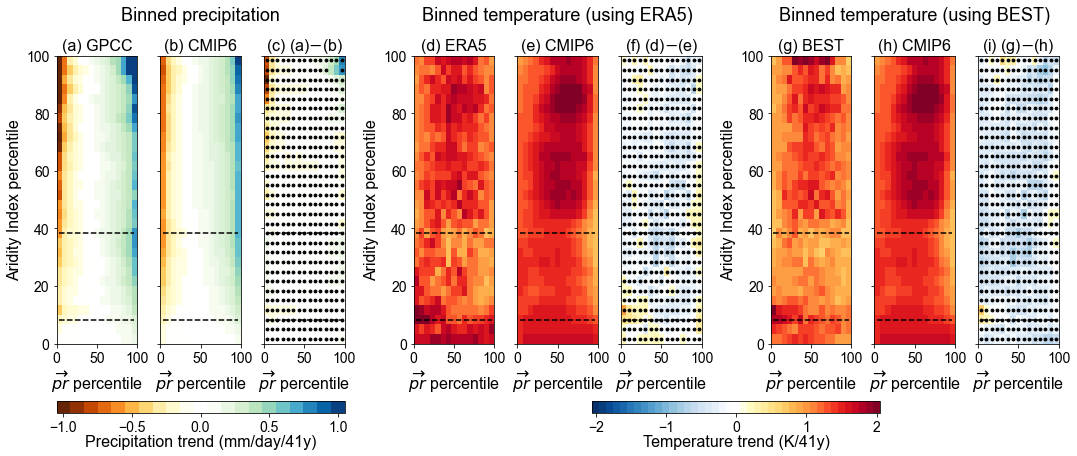

In [9]:
fig = plt.figure(figsize=(16,16))

ax = plot_binned_data(p_binned_era5, era5_binned.aridity_ptiles, 0.05,-1,1,'(a) GPCC',0.,0.07,0.68,0.93, ylabel=True)
ax = plot_binned_data(p_binned_cmip6em,era5_binned.aridity_ptiles, 0.05,-1,1,'(b) CMIP6',0.09,0.16,0.68,0.93)
ax = plot_binned_data(p_binned_era5 - p_binned_cmip6em,era5_binned.aridity_ptiles, 0.05,-1,1,'(c) (a)$-$(b)',0.18,0.25,0.68,0.93, 
                      signifdat=p_binned_signif)
fig.text(0.125, 0.965,'Binned precipitation', fontsize=18, ha='center', va='center')

ax = plot_binned_data_t(t_binned_era5, era5_binned.aridity_ptiles, 0.1,-2,2,'(d) ERA5',0.31,0.38,0.68,0.93,ylabel=True)
ax = plot_binned_data_t(t_binned_cmip6em, era5_binned.aridity_ptiles,0.1,-2,2,'(e) CMIP6',0.4,0.47,0.68,0.93)
ax = plot_binned_data_t(t_binned_era5 - t_binned_cmip6em, era5_binned.aridity_ptiles,0.1,-2,2,'(f) (d)$-$(e)',0.49,0.56,0.68,0.93,signifdat=t_binned_signif_era5)
fig.text(0.435, 0.965,'Binned temperature (using ERA5)', fontsize=18, ha='center', va='center')

ax = plot_binned_data_t(t_binned_best, era5_binned.aridity_ptiles, 0.1,-2,2,'(g) BEST',0.62,0.69,0.68,0.93,ylabel=True)
ax = plot_binned_data_t(t_binned_cmip6em, era5_binned.aridity_ptiles,0.1,-2,2,'(h) CMIP6',0.71,0.78,0.68,0.93)
ax = plot_binned_data_t(t_binned_best - t_binned_cmip6em, era5_binned.aridity_ptiles,0.1,-2,2,'(i) (g)$-$(h)',0.8,0.87,0.68,0.93,signifdat=t_binned_signif_era5)
fig.text(0.745, 0.965,'Binned temperature (using BEST)', fontsize=18, ha='center', va='center')


ax = cbars.plotcolorbar(fig, 0.1, -1, 1,'Precipitation trend (mm/day/41y)', 0.,0.25,0.62,0.63,cmap='precip')
ax = cbars.plotcolorbar(fig, 0.1, -2, 2,'Temperature trend (K/41y)', 0.59-0.125, 0.59+0.125, 0.62,0.63)

fig.savefig(plotpath+'figS14.pdf', bbox_inches='tight', facecolor='white')
